In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import layers

import numpy as np
import matplotlib.pyplot as plt

2025-03-14 17:45:55.857331: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-14 17:45:55.867174: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-14 17:45:55.933440: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-14 17:45:55.998155: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741967156.047780   11962 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741967156.06

In [2]:
from keras import backend as K
print(K.backend())

tensorflow


In [3]:
# Create the model
inputs = keras.Input(shape=(784,))
x = layers.Dense(256, activation="relu")(inputs)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")

2025-03-14 17:47:53.645541: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [4]:
model.summary()

Model: "mnist_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 203,530 (795.04 KB)

 Trainable params: 203,530 (795.04 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [6]:
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"],
)

In [7]:
history = model.fit(x_train, y_train, batch_size=64, epochs=10, validation_split=0.2)

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8640 - loss: 0.4853 - val_accuracy: 0.9561 - val_loss: 0.1550
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9630 - loss: 0.1285 - val_accuracy: 0.9682 - val_loss: 0.1171
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9765 - loss: 0.0806 - val_accuracy: 0.9713 - val_loss: 0.1001
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9837 - loss: 0.0582 - val_accuracy: 0.9741 - val_loss: 0.0882
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9878 - loss: 0.0426 - val_accuracy: 0.9737 - val_loss: 0.0907
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9922 - loss: 0.0312 - val_accuracy: 0.9743 - val_loss: 0.0903
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9926 - loss: 0.0269 - val_accuracy: 0.9753 - val_loss: 0.0857
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9951 - loss: 0.0189 - val_accuracy: 0.

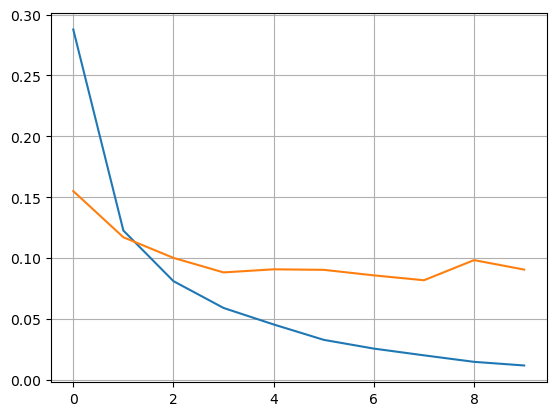

In [8]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.grid()
plt.show()

In [9]:
test_scores = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

313/313 - 0s - 1ms/step - accuracy: 0.9797 - loss: 0.0729
Test loss: 0.07286151498556137
Test accuracy: 0.9797000288963318


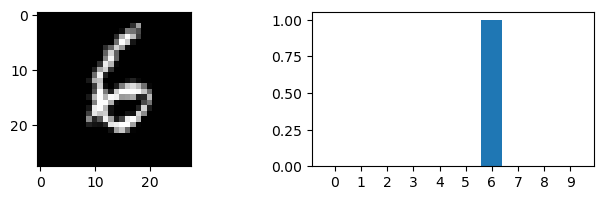

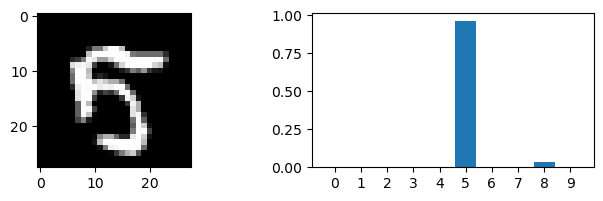

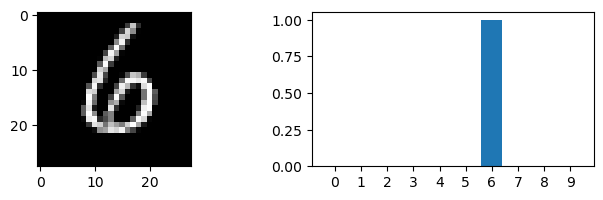

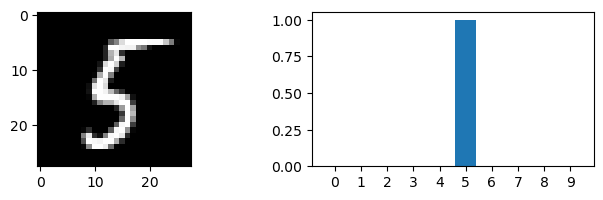

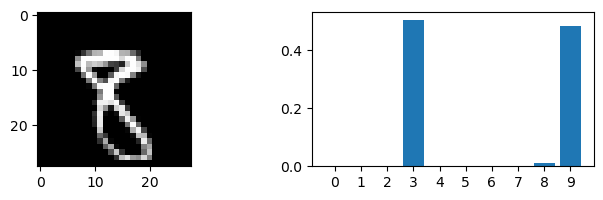

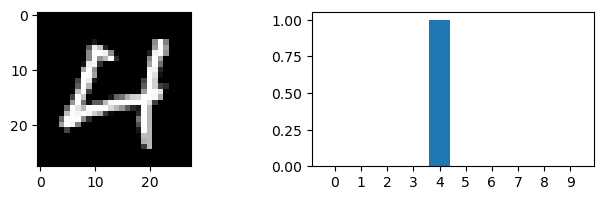

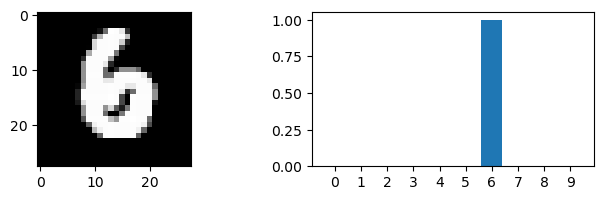

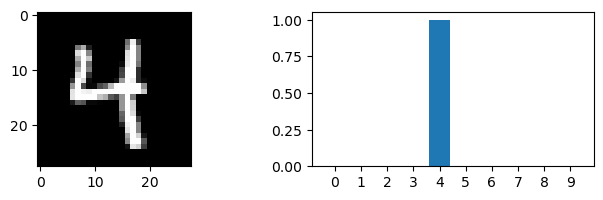

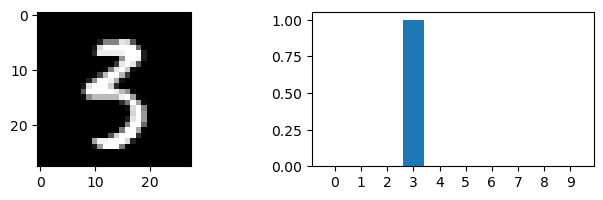

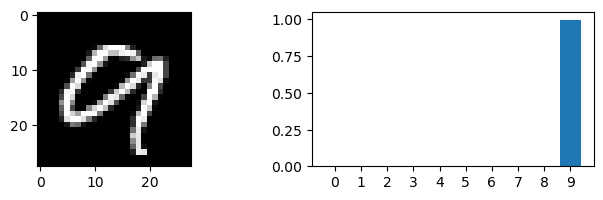

In [12]:
x = x_test
y = model(x)
start = 2000

for k in range(10):
    plt.figure(figsize=(8, 2))
    plt.subplot(1,2,1)
    plt.imshow(x[start+k].reshape((28, 28)), cmap='gray')
    ind = np.arange(0, 10)
    plt.subplot(1,2,2)
    plt.bar(ind, y[start+k].numpy().flatten())
    plt.xticks(range(10))